<a href="https://colab.research.google.com/github/rupachitta/bits-mtech-project-nlp/blob/main/Banking_Call_NLP_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP-based Topic Modeling & Intent Discovery Demo
End-to-end pipeline on banking call transcripts: preprocessing → topic modeling → intent clustering → summarization → retrieval QA.
**Files included:** `banking_calls_sample.csv`

In [3]:
# Optional: install dependencies (uncomment if needed)
# !pip install -q pandas scikit-learn sentence-transformers hdbscan umap-learn transformers torch matplotlib

import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Robust imports for optional libs
try:
    from sentence_transformers import SentenceTransformer
    _HAS_ST = True
except Exception as e:
    print("sentence-transformers not available, falling back to TF-IDF only:", e)
    _HAS_ST = False

try:
    import hdbscan
    _HAS_HDBSCAN = True
except Exception as e:
    print("hdbscan not available, will use KMeans:", e)
    _HAS_HDBSCAN = False

try:
    from transformers import pipeline
    _HAS_HF = True
except Exception as e:
    print("transformers not available; summarization will be simple extractive:", e)
    _HAS_HF = False

print("Libraries ready.")

Libraries ready.


In [4]:
# Load sample data
df = pd.read_csv(r"/mnt/data/banking_calls_sample.csv")
df.head()

,call_id,transcript
0,1,"Hello, I want to check my savings account bala..."
1,2,My credit card was charged twice at a store ye...
2,3,I forgot my net banking password. Can you help...
3,4,How can I close my loan? I have paid all EMIs ...
4,5,I want to update my registered mobile number a...


In [5]:
# Basic cleaning
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"[^a-z0-9 \-']", " ", t)
    return t.strip()

df['cleaned'] = df['transcript'].apply(clean_text)
df[['call_id', 'transcript', 'cleaned']].head()

,call_id,transcript,cleaned
0,1,"Hello, I want to check my savings account bala...",hello i want to check my savings account bala...
1,2,My credit card was charged twice at a store ye...,my credit card was charged twice at a store ye...
2,3,I forgot my net banking password. Can you help...,i forgot my net banking password can you help...
3,4,How can I close my loan? I have paid all EMIs ...,how can i close my loan i have paid all emis ...
4,5,I want to update my registered mobile number a...,i want to update my registered mobile number a...


In [6]:
# TF-IDF representation
tfidf = TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1,2))
X = tfidf.fit_transform(df['cleaned'])
len(tfidf.get_feature_names_out()), X.shape

(446, (40, 446))

## Topic Modeling (LDA & NMF)

In [7]:
# LDA topics
lda = LatentDirichletAllocation(n_components=6, random_state=42, learning_method='batch')
lda_topics = lda.fit_transform(X)

terms = tfidf.get_feature_names_out()
def top_terms_for_components(components, topn=10):
    topics = []
    for comp in components:
        top_idx = np.argsort(comp)[-topn:][::-1]
        topics.append([terms[i] for i in top_idx])
    return topics

lda_top_terms = top_terms_for_components(lda.components_, topn=12)
for i, t in enumerate(lda_top_terms):
    print(f"LDA Topic {i}: ", ", ".join(t))

LDA Topic 0:  help, branch, account, download account, months, pdf, statement months, months pdf, account statement, help download, poor service, help register
LDA Topic 1:  savings account, savings, process, transfer, account, rates, balance, want, close savings, know process, process close, account transfer
LDA Topic 2:  signature, account, want, debited, failed, upi payment, automatic refund, automatic, payment failed, failed debited, debited automatic, improve eligibility
LDA Topic 3:  fixed deposit, fixed, details, deposit, card, open, open fixed, online current, deposit online, current rate, current, rate
LDA Topic 4:  want, card, upcoming, enable, international, otp phone, phone online, receiving, receiving otp, otp, online transactions, phone
LDA Topic 5:  emi, twice, credit card, credit, refund, card, big, big purchase, card charges, convert, emi credit, convert big


In [8]:
# NMF topics (often more coherent with TF-IDF)
nmf = NMF(n_components=6, random_state=42, init='nndsvd')
nmf_topics = nmf.fit_transform(X)
nmf_top_terms = top_terms_for_components(nmf.components_, topn=12)
for i, t in enumerate(nmf_top_terms):
    print(f"NMF Topic {i}: ", ", ".join(t))

NMF Topic 0:  want, loan, balance, know, want know, close, process, transfer, savings, savings account, eligibility, closure
NMF Topic 1:  card, credit, credit card, purchase, debit card, transaction, emi, debit, immediately, dispute, twice, big purchase
NMF Topic 2:  deposit, fixed, fixed deposit, online, rates, current rate, current, online current, rate, open fixed, open, deposit online
NMF Topic 3:  help, account, set, download account, help download, account statement, statement months, months, months pdf, pdf, statement, download
NMF Topic 4:  address, mobile, new, update, bank, chequebook, chequebook delivered, bank records, change address, delivered, address bank, change
NMF Topic 5:  enable, international, payment, fees, fees payment, education fees, enable international, international remittance, education, remittance education, remittance, payment account


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## Intent Discovery (Embeddings + Clustering)

In [9]:
# Build embeddings
if _HAS_ST:
    st_model = SentenceTransformer('all-MiniLM-L6-v2')
    E = st_model.encode(df['cleaned'], show_progress_bar=False)
else:
    # Fallback to TF-IDF dense vectors
    E = X.toarray()

import numpy as np
print("Embedding shape:", np.array(E).shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding shape: (40, 384)


In [10]:
# Cluster with HDBSCAN if available, else KMeans
if _HAS_HDBSCAN:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
    labels = clusterer.fit_predict(E)
    algo = "HDBSCAN"
else:
    k = 6
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(E)
    algo = "KMeans"

import pandas as pd
df['intent_cluster'] = labels
print("Clustering algorithm:", algo)
df['intent_cluster'].value_counts().sort_index()

Clustering algorithm: HDBSCAN


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,count
intent_cluster,
-1,21
0,12
1,7


In [11]:
# Simple cluster summaries: top TF-IDF terms per cluster
from collections import defaultdict
cluster_texts = defaultdict(list)
for text, lab in zip(df['cleaned'], df['intent_cluster']):
    cluster_texts[lab].append(text)

def top_tfidf_terms_for_docs(docs, vectorizer, topn=10):
    if not docs:
        return []
    X_local = vectorizer.transform(docs)
    mean_vec = np.asarray(X_local.mean(axis=0)).ravel()
    idx = np.argsort(mean_vec)[-topn:][::-1]
    terms = vectorizer.get_feature_names_out()
    return [terms[i] for i in idx]

cluster_keywords = {c: top_tfidf_terms_for_docs(txts, tfidf, topn=10)
                    for c, txts in cluster_texts.items() if c != -1}
cluster_keywords

{0: ['loan',
  'want',
  'fixed deposit',
  'fixed',
  'rates',
  'process',
  'deposit',
  'balance',
  'account',
  'download'],
 1: ['card',
  'debit card',
  'transaction',
  'upcoming',
  'reset',
  'debit',
  'dispute',
  'credit',
  'credit card',
  'want']}

In [12]:
# Silhouette score (only if more than 1 cluster label present)
from sklearn.metrics import silhouette_score
import numpy as np
unique_labels = [l for l in np.unique(df['intent_cluster']) if l != -1]
if len(unique_labels) > 1:
    try:
        sil = silhouette_score(np.array(E), [l if l != -1 else 9999 for l in df['intent_cluster']], metric='euclidean')
        print("Silhouette score (approx, treating -1 as separate):", sil)
    except Exception as e:
        print("Silhouette score could not be computed:", e)
else:
    print("Not enough clusters for silhouette scoring.")

Silhouette score (approx, treating -1 as separate): 0.023443725


## Visualization (optional UMAP)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


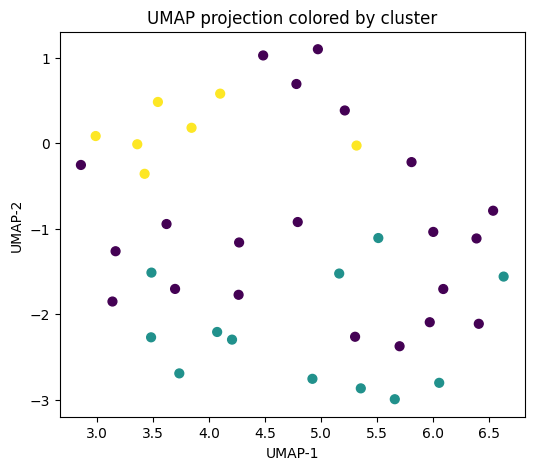

In [13]:
# Optional 2D projection via UMAP for scatter plot
try:
    import umap
    reducer = umap.UMAP(random_state=42, n_neighbors=10, min_dist=0.1)
    Z = reducer.fit_transform(E)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=df['intent_cluster'], s=40)
    plt.title("UMAP projection colored by cluster")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.show()
except Exception as e:
    print("UMAP not available:", e)

## Abstractive Summarization of a Cluster

In [14]:
# Summarize the most populous cluster
target_cluster = df['intent_cluster'].value_counts().index[0]
subset = df[df['intent_cluster']==target_cluster]['transcript'].tolist()[:6]
cluster_text = " ".join(subset)

try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
except Exception as e:
    pass

if _HAS_HF:
    try:
        from transformers import pipeline
        summarizer = pipeline("summarization", model="t5-small")
        out = summarizer(cluster_text, max_length=80, min_length=25, do_sample=False)
        print("Summary:", out[0]['summary_text'])
    except Exception as e:
        print("HF summarization failed; falling back to extractive:", e)
        # Simple extractive: pick 2 most central sentences by TF-IDF cosine
        sents = subset
        V = TfidfVectorizer(stop_words='english').fit_transform(sents)
        sim = cosine_similarity(V)
        centrality = sim.mean(axis=1)
        top_idx = centrality.argsort()[-2:][::-1]
        print("Summary:", " ".join([sents[i] for i in top_idx]))
else:
    # Simple extractive fallback
    sents = subset
    V = TfidfVectorizer(stop_words='english').fit_transform(sents)
    sim = cosine_similarity(V)
    centrality = sim.mean(axis=1)
    top_idx = centrality.argsort()[-2:][::-1]
    print("Summary:", " ".join([sents[i] for i in top_idx]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary: I see a non-maintenance fee last month. I lost my phone . please disable mobile banking for safety and reissue SIM linked services .


## Retrieval-style QA (without full RAG)

In [15]:
# Given a business question, retrieve top similar calls and summarize
question = "How to dispute an unauthorized credit card transaction and get refund?"
q_vec = tfidf.transform([question])
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(q_vec, X).ravel()
top_k = sims.argsort()[-5:][::-1]
print("Top related call IDs:", df.iloc[top_k]['call_id'].tolist())
print("Snippets:")
for i in top_k:
    print("-", df.iloc[i]['transcript'])

# Summarize those snippets
snips = df.iloc[top_k]['transcript'].tolist()
if _HAS_HF:
    try:
        from transformers import pipeline
        summarizer = pipeline("summarization", model="t5-small")
        out = summarizer(" ".join(snips), max_length=80, min_length=25, do_sample=False)
        print("\nAnswer Summary:", out[0]['summary_text'])
    except Exception as e:
        print("HF summarization failed; returning extractive:", e)
        print("\nAnswer Summary:", " ".join(snips[:2]))
else:
    print("\nAnswer Summary:", " ".join(snips[:2]))

Top related call IDs: [2, 6, 20, 28, 10]
Snippets:
- My credit card was charged twice at a store yesterday. I need to raise a dispute and get a refund.
- There is an unauthorized transaction on my debit card. Please block the card immediately.
- I want to dispute a fraudulent online transaction made using my card details.
- Can I convert my big purchase into EMI on the credit card? What are the charges?
- I want to increase my credit card limit temporarily for an upcoming purchase.


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Answer Summary: my credit card was charged twice at a store yesterday . there is an unauthorized transaction on my debit card . please block the card immediately .


---
**Done.** You can swap models, tweak `n_components`, or export results to CSV for the report.